In [1]:
import sys 
import matplotlib.pyplot as plt
import numpy as n
import time
from PIL import Image
from numpy import asarray
from tqdm import tqdm

PODMR - repetitions at each point

Necessary classes and functions

In [6]:
class PulseSequence:
    '''
    A pulse sequence to be loaded that is made of PulseBlock instances. The pulse blocks can be repeated
    as well and multiple can be added.
    '''
    def __init__(self):
        self.pulse_dict = {'d0':[], 'd1':[], 'd2':[], 'd3':[], 'd4':[], 'd5':[], 'd6':[], 'd7':[], 'a0':[], 'a1':[]}

    def append(self, block_list):
        '''
        append a list of tuples of type: 
        [(PulseBlock_instance_1, n_repetitions), (PulseBlock_instance_2, n_repetitions)]
        '''
        for block, n in block_list:
            for i in range(n):
                for key in block.block_dict.keys():
                    self.pulse_dict[key].extend(block.block_dict[key])

    
class PulseBlock:
    '''
    Small repeating pulse blocks that can be appended to a PulseSequence instance
    '''
    def __init__(self):
        self.block_dict = {'d0':[], 'd1':[], 'd2':[], 'd3':[], 'd4':[], 'd5':[], 'd6':[], 'd7':[], 'a0':[], 'a1':[]}
    
    def append(self, init_length, channels, repetition):
        '''
        init_length in s; will be converted by sequence class to ns
        channels are digital channels of PS in swabian language
        '''
        for i in range(repetition):
            for chn in channels.keys():
                self.block_dict[chn].extend([(init_length/1e-9, channels[chn])])

def set_up_odmr(pi_pulse=100e-9):
    """ 
    @param float clock_frequency: if defined, this sets the frequency of the
                                  clock
    @param str clock_channel: if defined, this is the physical channel of
                              the clock

    @return int: error code (0:OK, -1:error)
    """
    channels = {'d0': 0.0 , 'd1': 0.0 , 'd2': 0.0 , 'd3': 0.0 , 'd4': 0.0 , 'd5': 0.0 , 'd6': 0.0 , 'd7': 0.0 , 'a0': 0.0, 'a1': 0.0}
    clear = lambda x: {i:0.0 for i in x.keys()}
    d_ch = lambda x: f'd{x}'
    a_ch = lambda x: f'a{x}'

    seq = PulseSequence()
    block_1 = PulseBlock()

    channels = clear(channels)
    channels[a_ch(pulsestreamer._laser_analog_channel)] = pulsestreamer._laser_power_voltage
    channels[d_ch(pulsestreamer._mw_switch)] = 1.0
    block_1.append(init_length = pi_pulse, channels = channels, repetition = 1)
    
    channels = clear(channels)
    channels[a_ch(pulsestreamer._laser_analog_channel)] = pulsestreamer._laser_power_voltage
    block_1.append(init_length = 1e-6, channels = channels, repetition = 1)
    
    channels = clear(channels)
    channels[d_ch(pulsestreamer._laser_channel)] = 1.0
    channels[a_ch(pulsestreamer._laser_analog_channel)] = pulsestreamer._laser_power_voltage
    channels[d_ch(pulsestreamer._pixel_start)] = 1.0 # pulse to TT channel detect
    block_1.append(init_length = 3e-6, channels = channels, repetition = 1)
    
    channels = clear(channels)
    channels[a_ch(pulsestreamer._laser_analog_channel)] = pulsestreamer._laser_power_voltage
    block_1.append(init_length = 1.5e-6, channels = channels, repetition = 1)

    seq.append([(block_1, 1)])

    pulse_dict = seq.pulse_dict

    pulsestreamer.load_swabian_sequence(pulse_dict)
    return pulsestreamer._seq

def set_up_next_trigger():
    """ 
    @param float clock_frequency: if defined, this sets the frequency of the
                                  clock
    @param str clock_channel: if defined, this is the physical channel of
                              the clock

    @return int: error code (0:OK, -1:error)
    """
    channels = {'d0': 0.0 , 'd1': 0.0 , 'd2': 0.0 , 'd3': 0.0 , 'd4': 0.0 , 'd5': 0.0 , 'd6': 0.0 , 'd7': 0.0 , 'a0': 0.0, 'a1': 0.0}
    clear = lambda x: {i:0.0 for i in x.keys()}
    d_ch = lambda x: f'd{x}'
    a_ch = lambda x: f'a{x}'

    seq = PulseSequence()
    block_1 = PulseBlock()

    channels = clear(channels)
    channels[a_ch(pulsestreamer._laser_analog_channel)] = pulsestreamer._laser_power_voltage
    block_1.append(init_length = 1e-3, channels = channels, repetition = 1)
    
    channels = clear(channels)
    channels[a_ch(pulsestreamer._laser_analog_channel)] = pulsestreamer._laser_power_voltage
    channels[d_ch(pulsestreamer._pixel_stop)] = 1.0
    block_1.append(init_length = 1e-3, channels = channels, repetition = 1)
    
    channels = clear(channels)
    channels[a_ch(pulsestreamer._laser_analog_channel)] = pulsestreamer._laser_power_voltage
    block_1.append(init_length = 1e-3, channels = channels, repetition = 1)
    
    seq.append([(block_1, 1)])

    pulse_dict = seq.pulse_dict

    pulsestreamer.load_swabian_sequence(pulse_dict)
    return pulsestreamer._seq

Run measurement

In [20]:
var_list = np.linspace(2.83e9, 2.87e9, 5, endpoint=True)
mw_power = -20
pi_pulse=274e-9
num_runs = 20000

print(mw_source_smbv.set_list(var_list, mw_power)) # 

mw_source_smbv.list_on()
laser_pulses = len(var_list)

bin_width_s = 1e-9
record_length_s = 3e-6

ret_val = time_tagger.configure_recorder(
                mode=11, # pulsed mode
                params={'laser_pulses': laser_pulses,
                        'bin_width_s': bin_width_s,
                        'record_length_s': record_length_s,
                        'max_counts': 1} )

time_tagger.start_recorder(arm=True)
set_up_next_trigger()
time_tagger._tagger.sync()
time.sleep(1)
print(time_tagger.recorder.getHistogramIndex())
pulsestreamer.pulser_on(n=int(1))
while True:
    time.sleep(0.001)
    if pulsestreamer.pulse_streamer.hasFinished():
        break
time.sleep(1)
print(time_tagger.recorder.getHistogramIndex())
podmr = set_up_odmr(pi_pulse)

for i in tqdm(range(laser_pulses)):
    pulsestreamer.pulser_on(n=num_runs, final=pulsestreamer._mw_trig_final_state)
    d =time.time()
    while True:
        if time_tagger.recorder.getHistogramIndex() > i or (time.time()-d)>2 or time_tagger.recorder.getCounts()>0:
            time.sleep(0.001)
            break

pulsestreamer.pulser_off()
mw_source_smbv.off()   

(2757000000.0, -16.0, 'list')
0
0


100%|######################################################################################################################################################################################################################| 5/5 [00:00<00:00, 54.53it/s]


0

In [12]:
pulsed_meas = time_tagger.get_measurements()[0]
pulsed_meas

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

Plot Jupyter data

[[Model]]
    (((Model(amplitude_function, prefix='l0_') * Model(physical_lorentzian, prefix='l0_')) + Model(constant_function)) + (Model(amplitude_function, prefix='l1_') * Model(physical_lorentzian, prefix='l1_')))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 140
    # data points      = 5
    # variables        = 5
    chi-square         = 1.1207e-04
    reduced chi-square = inf
    Akaike info crit   = -43.5291657
    Bayesian info crit = -45.4819762
[[Variables]]
    l0_amplitude: -0.02180360 +/- 0.00000000 (0.00%) (init = -0.004175578)
    l0_center:     2.8445e+09 +/- 0.00000000 (0.00%) (init = 2.845e+09)
    l0_sigma:      5000000.00 +/- 0.00000000 (0.00%) (init = 5000000)
    offset:        1.13553379 +/- 0.00000000 (0.00%) (init = 1.126217)
    l1_amplitude: -1.0034e-06 +/- 0.00000000 (0.00%) (init = -0.004175578)
    l1_center:     2.8475e+09 +/- 0.00000000 (0.00%) == 'l0_center+3030000.0'
    l1_sigma:      5000000.00 +/- 0.00000000 (0.00%) =

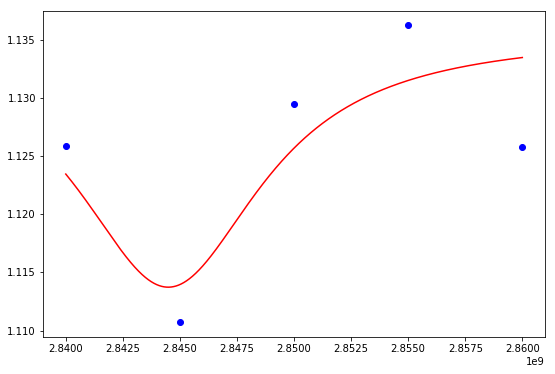

In [7]:
data,_ =afm_scanner_logic.analyse_pulsed_meas(pulsedmasterlogic.analysis_settings, pulsed_meas)

# fit = afm_scanner_logic._fitlogic.make_lorentzian_fit(var_list,data,estimator=afm_scanner_logic._fitlogic.estimate_lorentzian_dip)
fit = afm_scanner_logic._fitlogic.make_lorentziandouble_fit(var_list,data,estimator=afm_scanner_logic._fitlogic.estimate_lorentziandouble_N15)
print(fit.fit_report())
# lm,_ = fitlogic.make_lorentzian_model()
lm,_ = fitlogic.make_lorentziandouble_model()
plt.plot(var_list, data,'bo')
x = np.linspace(var_list[0],var_list[-1],10000, endpoint=True)
plt.plot(x, lm.eval(fit.params, x=x),'r-')
plt.show()

Plot SPM data

In [2]:
d = afm_scanner_logic._pulsed_scan_array['pulsed_fw']

In [4]:
d.keys()

dict_keys(['data', 'data_alternating', 'data_std', 'data_alternating_std', 'data_fit', 'data_alternating_fit', 'data_delta', 'data_raw', 'coord0_arr', 'coord1_arr', 'coord2_arr', 'measured_units', 'scale_fac', 'si_units', 'nice_name', 'params', 'display_range'])

In [3]:
afm_scanner_logic._qafm_scan_array.keys()

dict_keys(['counts_fw', 'counts2_fw', 'counts_diff_fw', 'b_field_fw', 'fit_param_fw', 'Height(Dac)_fw', 'counts_bw', 'counts2_bw', 'counts_diff_bw', 'b_field_bw', 'fit_param_bw', 'Height(Dac)_bw'])

In [5]:
q = afm_scanner_logic._qafm_scan_array['fit_param_fw']

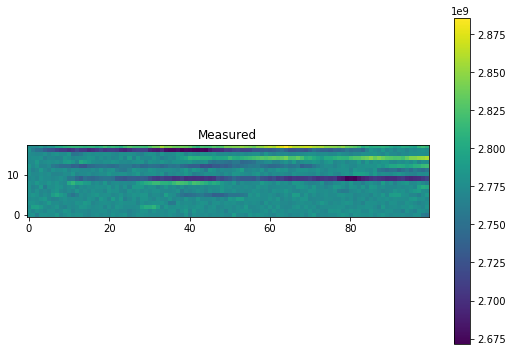

In [10]:
meas = q['data'][:18,:]
ax = plt.subplot()
im = ax.imshow(meas, origin='lower')
plt.title('Measured')
plt.colorbar(im)
plt.show()

CW Analysis

In [28]:
d = afm_scanner_logic._esr_scan_array['esr_fw']['data']
x = afm_scanner_logic._esr_scan_array['esr_fw']['coord2_arr']

100%|#####################################################################################################################################################################################################################| 20/20 [00:27<00:00,  1.40s/it]


In [19]:
d = afm_scanner_logic._pulsed_scan_array['pulsed_fw']['data']
x = afm_scanner_logic._pulsed_scan_array['pulsed_fw']['coord2_arr']

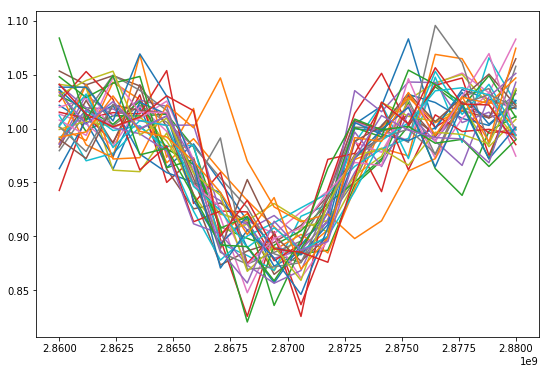

In [20]:
for i in range(35):
    plt.plot(x,d[0,i])
plt.show()

In [12]:
scale = 0
scale_dx = 0
# plt.figure(figsize=(3,9))
for i in range(1):
    data = d[1,i,:]
    data =(data - np.mean(data))/np.max(data)
    fit = afm_scanner_logic._fitlogic.make_lorentziandouble_fit(x,data,estimator=afm_scanner_logic._fitlogic.estimate_lorentziandouble_dip)
#     print(fit.fit_report())
    lm,_ = fitlogic.make_lorentziandouble_model()
    scale += np.median(data)*0.2
#     plt.plot(x, data+scale,'b-')

    x1 = np.linspace(x[0],x[-1],100, endpoint=True)
    dx1 = x1[1]-x1[0]
    dx = x[1]-x[0]
    
    y_fit = lm.eval(fit.params, x=x1)
    y1 = np.gradient(y_fit, dx1)
    y2 = np.gradient(data, dx)
    scale_dx += np.max(y2)*1.5 * 0
    
#     plt.plot(x1, (y_fit),'r-')
    rng = [30,40]
    plt.plot(x1[rng[0]:rng[1]], y1[rng[0]:rng[1]]+scale_dx,'r-')

plt.show()

Traceback (most recent call last):
  File "C:\Users\yy3\Documents\Software\qudi\logic\jupyterkernel\qzmqkernel.py", line 679, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-086516fda9c8>", line 7, in <module>
    fit = afm_scanner_logic._fitlogic.make_lorentziandouble_fit(x,data,estimator=afm_scanner_logic._fitlogic.estimate_lorentziandouble_dip)
  File "C:\Users\yy3\Documents\Software\qudi\logic\fitmethods\lorentzianlikemethods.py", line 460, in make_lorentziandouble_fit
    error, params = estimator(x_axis, data, params)
  File "C:\Users\yy3\Documents\Software\qudi\logic\fitmethods\lorentzianlikemethods.py", line 534, in estimate_lorentziandouble_dip
    data_smooth, offset = self.find_offset_parameter(x_axis, data)
  File "C:\Users\yy3\Documents\Software\qudi\logic\fitmethods\generalmethods.py", line 480, in find_offset_parameter
    hist = np.histogram(data_smooth, bins=10)
  File "<__array_function__ internals>", line 6, in histogram
  

In [35]:
fit_param = np.zeros((d.shape[0],d.shape[1]))
for i in tqdm(range(d.shape[0])):
    for j in range(d.shape[1]):
        data = d[i,j,:]
        fit = afm_scanner_logic._fitlogic.make_lorentziandouble_fit(x,data,estimator=afm_scanner_logic._fitlogic.estimate_lorentziandouble_dip)
        fit_param[i,j] = (fit.params['l1_center']-fit.params['l0_center'])/1
        if abs(fit.params['l1_contrast'])<2:
            fit_param[i,j] = 2.975e9-2.800e9

 95%|##########################################################################################################################################################################################################3          | 19/20 [00:26<00:01,  1.20s/it]

100%|#####################################################################################################################################################################################################################| 20/20 [00:27<00:00,  1.38s/it]


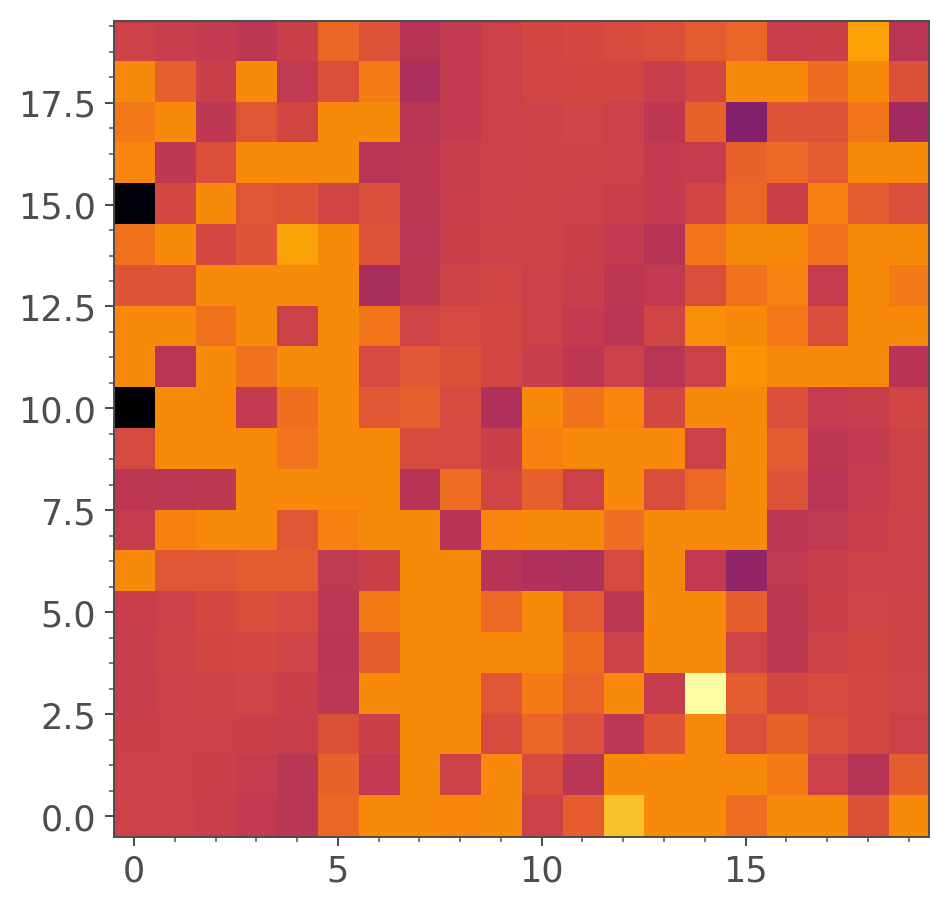

In [36]:
plt.imshow(fit_param, cmap=plt.get_cmap('inferno'), origin='lower')#,vmin=2850308429.723922-6e6, vmax=2850308429.723922+5e6)
plt.show()

## Tracking analysis testing

In [2]:
def tracking_analysis(pulsed_ret0, coord1_num, coord0_num, 
                      line_num, index, slope2_podmr, res_freq_array, prev, var_list):
    
        visibility = (pulsed_ret0[1] - pulsed_ret0[0])/(pulsed_ret0[1] + pulsed_ret0[0])
        estimation_freq =  prev - visibility/slope2_podmr
        return estimation_freq, visibility

# def tracking_analysis_point(pulsed_ret0, slope2_podmr, prev, var_list):
#         visibility = (pulsed_ret0[1] - pulsed_ret0[0])/(pulsed_ret0[1] + pulsed_ret0[0])
#         visibility = (pulsed_ret0[1] - pulsed_ret0[0])/(var_list[1] - var_list[0])
#         estiamtion_freq =  prev - visibility/slope2_podmr
#         return estiamtion_freq, visibility
    
def measure_two_points(lm, params, x1):
    y1 = lm.eval(params, x = x1)
    return y1
    
# def twoD_sin(point_num, coord0_num, freq, phase, line_num, coord1_num):
#     sig = np.sin(2 * np.pi * freq * point_num/coord0_num + phase)
# #     sig = np.sin(2 * np.pi * freq * line_num/coord1_num + phase)
#     return sig

# 2D algorithm test

In [3]:
# load the image
image = Image.open('G:\\Data\\Qudi_Data\\2023\\03\\20230306\\AttoDRY2200_Pi3_SPM\\20230306-1252-09_test_wall_data_QAFM.tiff')
# convert image to numpy array
fdata = asarray(image)

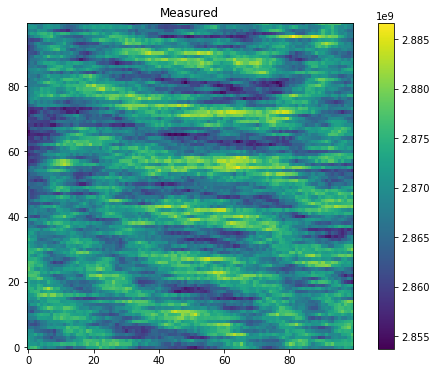

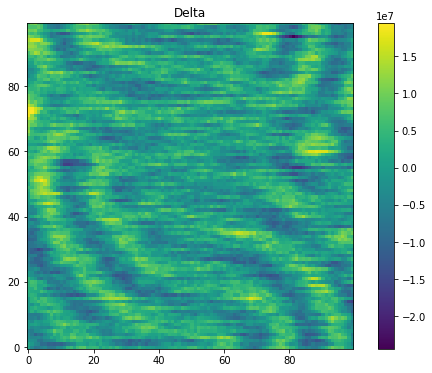

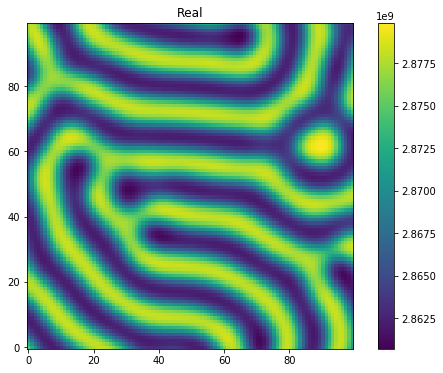

Mean: 4284252.025333455
Median: 3734050.296904564
Mean without first line: 4272501.800851347
Mean only first line: 5447524.249062104


In [32]:
coord0 = 200
coord1 = 200

data = fdata[:100,:100]
coord0 = data.shape[1]
coord1 = data.shape[0]

# true_res = np.ones([coord1,coord0]) * 2.87e9
true_res = ((data/np.mean(data)-np.max(data/np.mean(data))/2)*10e6) + 2.87e9

# meas_res = np.ones([coord1,coord0]) * 2.87e9
meas_res = np.zeros([coord1,coord0])
meas_res[0,0] = true_res[0,0]
fwhm = 12e6

lm,_ = fitlogic.make_lorentzian_model()
params = lm.make_params()
params['amplitude'].value = -0.14
params['offset'].value = 1.1
params['sigma'].value = fwhm/2

# l = 4
# shifting_freq = 5
# freq_shift = (fwhm * twoD_sin(0, coord0, shifting_freq, 0, 0, coord1)) / l
# freq_shift = 0 
# true_res0 = true_res[0,0] + freq_shift 
# res_estimate = true_res0
n_runs = 1
# K = 2.0930602356889494e-14
K = 29.4e-09
# ph=5

for j in range(coord1):
    for i in range(coord0):
#         freq_shift = (fwhm * twoD_sin(i, coord0, shifting_freq, 2*np.pi*j/coord1*ph, j, coord1)) / l + (np.random.random()*2e6)
#         true_res[j,i] += freq_shift 
        params['center'].value = true_res[j,i] # updates the model to keep up with true data  
        delta = 12e6 #params['fwhm']/2

        line_num = j
        index = i
        if line_num==0 and index==0:
            coord = (line_num,index)
        elif line_num!=0 and index==0:
            coord = (line_num-1,index)
        elif index!=0:
            coord = (line_num,index-1)
        res_estimate = meas_res[coord]
        
        for n in range(n_runs):
            var_list = np.array([res_estimate-delta, res_estimate+delta])
            pulsed_ret0 = measure_two_points(lm, params, var_list)  + np.random.random(2)/3
            res_estimate,vis = tracking_analysis(pulsed_ret0, coord1, coord0, j, i, K, meas_res,res_estimate, var_list)
#             if np.isclose(vis,0,rtol=0.001):
#                 meas_res[j,i] = res_estimate
#                 break
            meas_res[j,i] = res_estimate


ax = plt.subplot()
im = ax.imshow(meas_res, origin='lower')
plt.title('Measured')
plt.colorbar(im)
plt.show()

ax = plt.subplot()
im = ax.imshow(true_res-meas_res, origin='lower')
plt.title('Delta')
plt.colorbar(im)
plt.show()

ax = plt.subplot()
im = ax.imshow(true_res, origin='lower')
plt.title('Real')
plt.colorbar(im)
plt.show()
print(f'Mean: {np.mean(abs(true_res[:,:]-meas_res[:,:]))}')
print(f'Median: {np.median(abs(true_res[:,:]-meas_res[:,:]))}')
print(f'Mean without first line: {np.mean(abs(true_res[:,1:]-meas_res[:,1:]))}')
print(f'Mean only first line: {np.mean(abs(true_res[:,0]-meas_res[:,0]))}')

# Algorithm test

2.0930602356889494e-14
2.87175


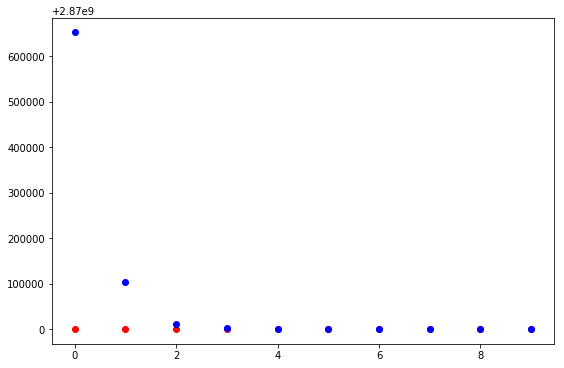

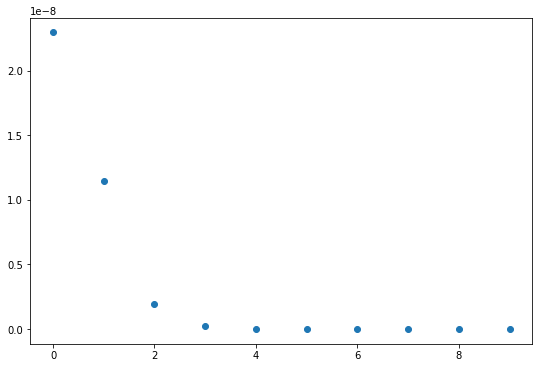

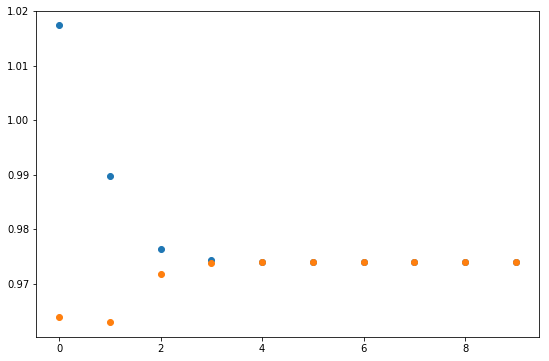

In [20]:
num_runs = 10

visibility = np.zeros(num_runs)
res_delta = np.zeros(num_runs)
true_res = np.ones(num_runs) * 2.87e9
meas_res = np.zeros(num_runs)
pulse_ret = np.zeros([2, num_runs])
fwhm = 7e6

lm,_ = fitlogic.make_lorentzian_model()
params = lm.make_params()
params['amplitude'].value = -0.14
params['offset'].value = 1.1
params['sigma'].value = fwhm/2
params['center'].value = true_res[0]

freq_shift = fwhm / 4
res_estimate = true_res[0] + freq_shift
meas_res[0] = res_estimate
delta = params['fwhm']/6

slope = 2.0930602356889494e-14

print(slope)
print(res_estimate/1e9)

for n in range(num_runs):
    var_list = np.array([res_estimate-delta, res_estimate+delta])
        
    pulsed_ret0 = measure_two_points(lm, params, var_list)
    
    res_estimate, vis = tracking_analysis_point(pulsed_ret0, slope, res_estimate, var_list)

    meas_res[n] = res_estimate
    visibility[n] = vis
    pulse_ret[:,n] = pulsed_ret0


plt.plot(np.arange(num_runs),true_res, 'ro')
plt.plot(np.arange(num_runs),meas_res, 'bo')
plt.show()

plt.plot(np.arange(num_runs),visibility, 'o')
plt.show()
# print(visibility)

plt.plot(np.arange(num_runs),pulse_ret[1], 'o', label='C1')
plt.plot(np.arange(num_runs),pulse_ret[0], 'o', label='C2')
plt.show()
# print(pulse_ret)
# plt.plot(res_delta[::])
# plt.show()


# Visibility and der. curve

3.671756458255524e-09


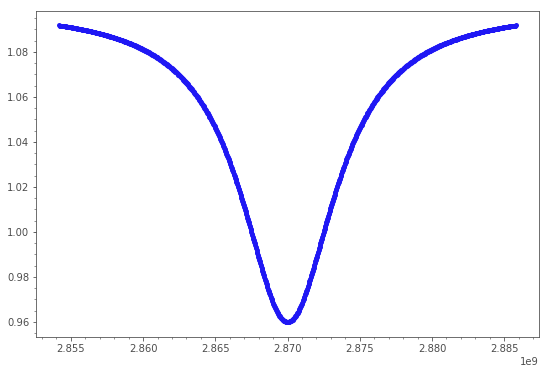

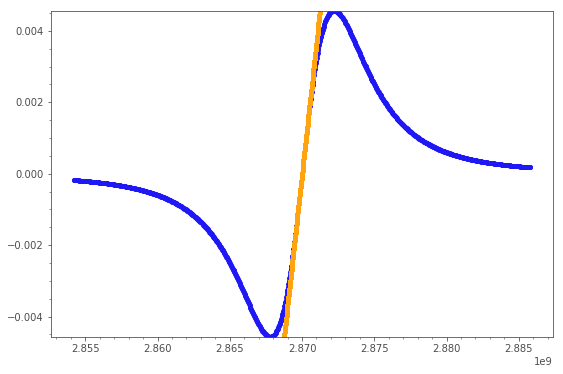

In [19]:
# function giving back visibility for a particular param set for lorentzian model
def vis(lm, param, res, delta):
    c2, c1 = lm.eval(param, x = np.array([res-delta, res+delta]))
    return (c1-c2)/(c1+c2)

lm,_ = fitlogic.make_lorentzian_model()
params = lm.make_params()
fwhm = 7.9e6
params['amplitude'].value = -0.14
params['offset'].value = 1.1
params['sigma'].value = fwhm/2
params['center'].value = 2.87e9
x = np.linspace(2.87e9-fwhm*2,2.87e9+fwhm*2,1001)
y = lm.eval(params,x=x)

fitt = fitlogic.make_lorentzian_fit(x,y,estimator=fitlogic.estimate_lorentzian_dip)

plt.plot(x,y)
plt.show()

vis_arr = np.array([vis(lm, params, x, fwhm/40) for x in x])
plt.plot(x,vis_arr)
# plt.show()
slope = np.gradient(vis_arr, x)[int(len(x)/2)]
print(slope)
m = slope
y = m*x + (-m*(2.87e9))
plt.plot(x,y)
plt.ylim(vis_arr.min(), vis_arr.max())
plt.show()

In [30]:
fitt.eval_uncertainty(x=x)

Traceback (most recent call last):
  File "C:\Users\yy3\Documents\Software\qudi\logic\jupyterkernel\qzmqkernel.py", line 679, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-30-111441fc9cf7>", line 1, in <module>
    fitt.eval_uncertainty(x=x)
  File "C:\Users\yy3\anaconda3\envs\qudi\lib\site-packages\lmfit\model.py", line 1345, in eval_uncertainty
    df2 += fjac[i]*fjac[j]*covar[i, j]
TypeError: 'NoneType' object is not subscriptable


# Testing tracking on measured data - starting of slightly off resonant and seeing the convergence to resonance

In [98]:
def measure_two_real_points(var_list, power):
    start = var_list[0]
    stop = var_list[1]
    step = stop-start
    data = podmrlogic.perform_odmr_measurement([start], [step], [stop], power, 0, 0, fit_function='No Fit', save_after_meas=False, name_tag='')
    return data[1][0]

In [94]:
odmrlogic._mw_device.set_sweep_2(2.754e9, 2.78e9, 1e6, -15)

(2754000000.0, 2780000000.0, 1000000.0, -15.0, 'sweep')

In [86]:
measure_two_real_points([round(2758623333.3333335,0), round(2760956666.6666665,0)], -10)

array([1.07060009, 1.12105651])

In [19]:
num_runs = 3
pihalf = 214e-9
power = -10
lines = 100000
center = 2.755e9

visibility = np.zeros(num_runs)
res_delta = np.zeros(num_runs)
true_res = np.ones(num_runs) * center
meas_res = np.zeros(num_runs)
pulse_ret = np.zeros([2, num_runs])

fwhm = 7e6

freq_shift = fwhm / 2
res_estimate = true_res[0] + freq_shift
meas_res[0] = res_estimate
delta = params['fwhm']/6

slope = 2.5909309154738298e-08

print(res_estimate)

for n in range(num_runs):
    var_list = [round(res_estimate-delta,0), round(res_estimate+delta,0)]
    print(var_list)    
    pulsed_ret0 = measure_two_real_points(var_list, power)
    
    res_estimate, vis = tracking_analysis_point(pulsed_ret0, slope, res_estimate)
    

    meas_res[n] = res_estimate
    visibility[n] = vis
    pulse_ret[:,n] = pulsed_ret0


plt.plot(np.arange(num_runs),true_res)
plt.plot(np.arange(num_runs),meas_res)
plt.show()

plt.plot(np.arange(num_runs),visibility)
plt.show()
# print(visibility)

plt.plot(np.arange(num_runs),pulse_ret[1], label='C1')
plt.plot(np.arange(num_runs),pulse_ret[0], label='C2')
plt.show()
# print(pulse_ret)
# plt.plot(res_delta[::])
# plt.show()


2758500000.0
[2757333333.0, 2759666667.0]


Traceback (most recent call last):
  File "C:\Users\yy3\Documents\Software\qudi\logic\jupyterkernel\qzmqkernel.py", line 679, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-19-a3ee892f8dcf>", line 27, in <module>
    pulsed_ret0 = measure_two_points(var_list, power)
TypeError: measure_two_points() missing 1 required positional argument: 'x1'
